Jupyter notebook中使用Anaconda中的环境需要单独配置，默认情况下使用的是系统默认的Python环境，以使用advbox环境为例。
首先在默认系统环境下执行以下命令，安装ipykernel。

    conda install ipykernel
    conda install -n advbox ipykernel

在advbox环境下激活，这样启动后就可以在界面上看到advbox了。

    python -m ipykernel install --user --name advbox --display-name advbox 


In [1]:
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

from mxnet import gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet import ndarray as nd
import matplotlib.pyplot as plt
import cv2
from mxnet import image
from mxnet import autograd
from advbox.adversary import Adversary
from advbox.attacks.gradient_method import FGSMT
from advbox.attacks.gradient_method import FGSM
from advbox.models.mxnet import MxNetModel
import numpy as np
from tools import show_images_diff

In [2]:
#定义被攻击的图片
image_path="tutorials/cropped_panda.jpg"

In [3]:
alexnet = mx.gluon.model_zoo.vision.alexnet(pretrained=True)

orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img = np.expand_dims(img, axis=0)

# advbox demo
m = MxNetModel(
    alexnet, None,(-3, 3),
    channel_axis=1)
attack = FGSMT(m)


# 静态epsilons
attack_config = {"epsilons": 0.2, "epsilon_steps": 1, "steps": 100}

inputs=img

print(inputs.shape)

adversary = Adversary(inputs, None)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]


else:
    print('attack failed')


print("fgsm attack done")


mxnet.py[line:54] INFO Finish MxNetModel init


(1, 3, 224, 224)


base.py[line:87] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
gradient_method.py[line:86] INFO epsilons=0.2,epsilons_max=0.5,steps=100,epsilon_steps=1
gradient_method.py[line:133] INFO step=1, epsilon = 0.20000, pre_label = 388, adv_label=388 logits=10.7582530975
gradient_method.py[line:133] INFO step=2, epsilon = 0.20000, pre_label = 388, adv_label=806 logits=8.05010509491
gradient_method.py[line:133] INFO step=3, epsilon = 0.20000, pre_label = 388, adv_label=538 logits=21.5946960449


attack success, adversarial_label=538
fgsm attack done


In [4]:
#格式转换
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


l0=150520 l2=65790.2171679


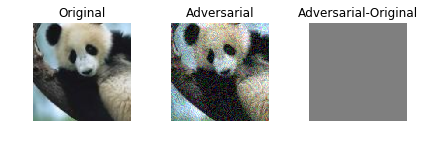

In [5]:
#显示原始图片  抵抗样本 以及两张图之间的差异  其中灰色代表没有差异的像素点
show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)